/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Coupling map:


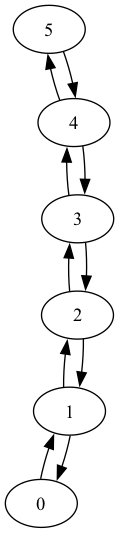

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

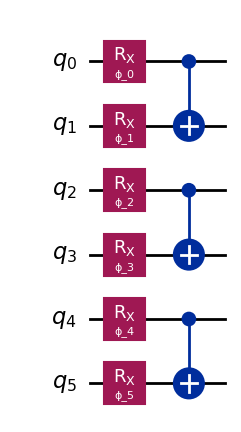

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


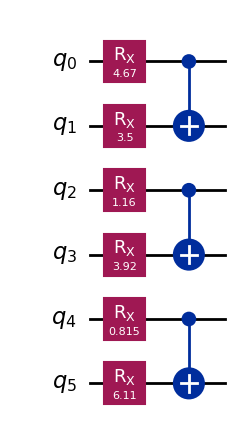

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

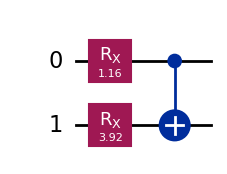

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

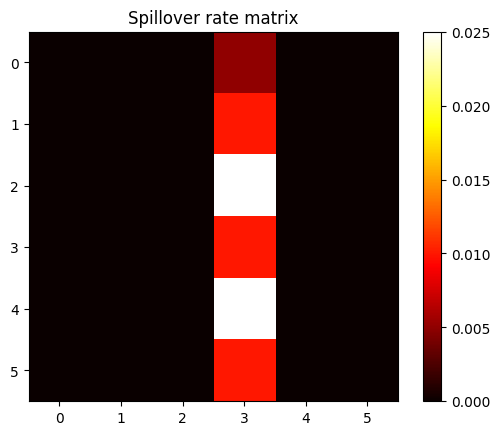

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 3] = 0.005  # γ_0->3
gamma_matrix[1, 3] = 0.01  # γ_1->3
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 3] = 0.01  # γ_2->3
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 3] = 0.01  # γ_5->3
# gamma_matrix[0, 2] = 0.01  # γ_0->2
# gamma_matrix[1, 2] = 0.025  # γ_1->2
# gamma_matrix[2, 2] = 0.01  # γ_1->2
# gamma_matrix[3, 2] = 0.025  # γ_3->2
# gamma_matrix[4, 2] = 0.01  # γ_4->2
# gamma_matrix[5, 2] = 0.005  # γ_5->2
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)

# Generate another gamma matrix based on coupling map defined above
# gamma_matrix = 0.0 * np.eye(num_qubits)
# for edge in cm.get_edges():
#     gamma_matrix[edge[0], edge[1]] = 0.05


# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0.   , 0.   , 0.   , 0.005, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.01 , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.01 , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.01 , 0.   , 0.   ]])

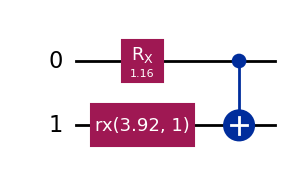

In [7]:
spillover_pass = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
causal_cone_pass = CausalConePass((2, 3))
pm = PassManager([spillover_pass, causal_cone_pass])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = circuit.assign_parameters(param_dict)
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [8]:
qc_noisy.qubits

[Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)]

In [9]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.1607433119572852]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        -0.92432454j, -0.38160732+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=())]

In [10]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [11]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '15ceebc4206a4a8ea9687756270f4cb6',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99459537+0.j      , 0.        -0.103827j],
              [0.        -0.103827j, 0.99459537+0.j      ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [12]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager(
    [spillover_pass, causal_cone_pass] + full_pm.translation._tasks[0]
)
full_pm.translation = custom_translation_pass

In [13]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x15f59b5d0>,

In [14]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [15]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '15ceebc4206a4a8ea9687756270f4cb6',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99459537+0.j      , 0.        -0.103827j],
              [0.        -0.103827j, 0.99459537+0.j      ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [16]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


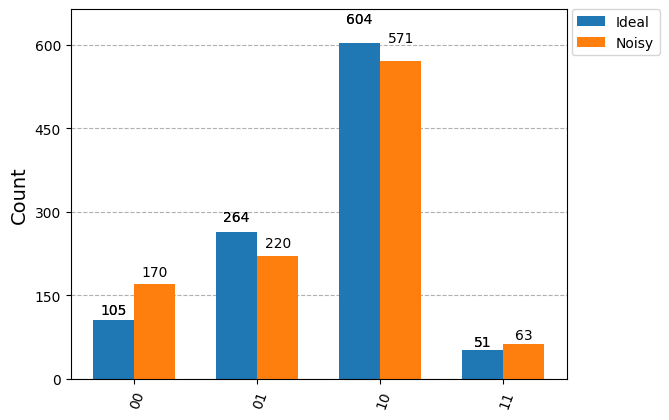

In [17]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [18]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [19]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9913759632466694

In [20]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


# def apply_parametrized_circuit(
#     qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
# ):
#     """
#     Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
#     This function is used to run the QuantumCircuit instance on a Runtime backend
#     :param qc: Quantum Circuit instance to add the gate on
#     :param params: Parameters of the custom Gate
#     :param q_reg: Quantum Register formed of target qubits
#     :return:
#     """
#     target = kwargs["target"]
#     my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
#     optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
#     # optimal_params = np.pi * np.zeros(len(params))
#     new_params = [optimal_params[i] + params[i] for i in range(len(params))]

#     my_qc.u(
#         new_params[0],
#         -np.pi/2,
#         np.pi/2,
#         q_reg[0],
#     )
#     my_qc.u(
#         0.,
#         new_params[1],
#         new_params[2],
#         q_reg[0],
#     )
#     my_qc.u(
#         *new_params[3:6],
#         q_reg[1],
#     )

#     my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

#     qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        new_params[0],
        -0.5 * np.pi,
        0.5 * np.pi,
        q_reg[0],
    )
    my_qc.u(
        0,
        new_params[1],
        new_params[2],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [21]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-0.3, high=0.3, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[10,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

In [22]:
# Constructing general angle spillover env

from general_angle_spillover_env import GeneralAngleSpilloverEnv

general_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=2,
    applied_qubits=[0, 1, 2, 3, 4, 5],
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)
rescaled_g_env = RescaleAndClipAction(general_env, min_action=-1., max_action=1.)

Observation Vals for Agent: [[-1.  -1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1.   1. ]]
Observation Vals for Env: [[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.78539816]
 [0.         0.         0.         0.         0.         1.57079633]
 ...
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 1.57079633]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 2.35619449]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]]


In [23]:
rescaled_g_env.unwrapped.batch_size

32

In [24]:
print(rescaled_g_env.unwrapped.discrete_obs_vals_raw)

[[-1.  -1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1.   1. ]]


In [25]:
obs, _ = rescaled_g_env.unwrapped.reset(
    debug_obs=rescaled_g_env.unwrapped.obs_raw_to_angles(np.array([1., 1., 1., 1., 1., 1.]))
)

Sampled angles:  [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]
Environment Observation: [1. 1. 1. 1. 1. 1.]


In [26]:
print(general_env.observation_space.shape[0])

6


In [27]:
print(gamma_matrix.T)

[[0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.005 0.01  0.025 0.01  0.025 0.01 ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]]


In [28]:
computed_spillover_angles = general_env.gamma_matrix.T @ general_env.phi_vec
print(computed_spillover_angles)
subsystem_spillover_angles = computed_spillover_angles[2:4]
print(subsystem_spillover_angles)
subsystem_spillover_angles / np.pi

opt_action = np.zeros((1, 7))
opt_action[0, [0, 3]] = -subsystem_spillover_angles

[0.         0.         0.         0.26703538 0.         0.        ]
[0.         0.26703538]


In [29]:
opt_action

array([[-0.        ,  0.        ,  0.        , -0.26703538,  0.        ,
         0.        ,  0.        ]])

Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9858229673831191
Reward (avg): 0.9858229673831191 Std: 0.0
Number of repetitions: 2
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9858229673831191
Reward (avg): 0.9442968108015772 Std: 0.0
Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9858229673831191
Reward (avg): 0.8783651186369255 Std: 0.0
Number of repetitions: 4
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9858229673831191
Reward (avg): 0.7927014696406861 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9858229673831191
Reward (avg): 0.6933781455423624 Std: 0.0
Number of repetitions: 6
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (

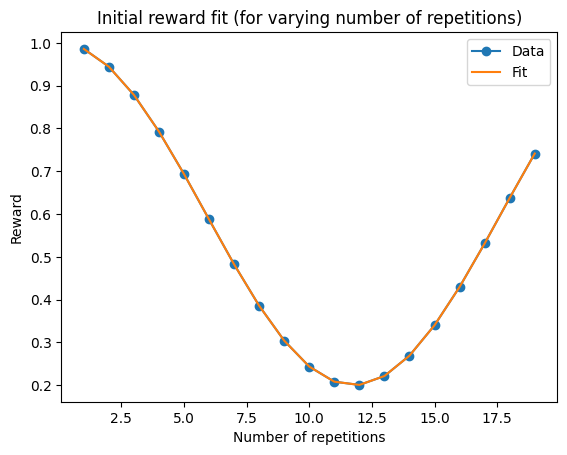

In [30]:
fig, reward_data = general_env.initial_reward_fit(
    np.zeros((1, 7)),
    # opt_action,
    ExecutionConfig(
        sampling_paulis=100,
        n_shots=10,
        n_reps=list(
            range(1, 20, 1),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="fidelity",
    fit_p0=list(subsystem_spillover_angles)
)

In [31]:
general_env.batch_size

32

In [32]:
# PPO Details

from ppo_cleaned_up import PPO
from context_sampling_wrapper import ContextSamplingWrapper

train_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[0, 1, 2, 3, 4, 5],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context-Aware Training",
    "wandb_entity": "quantumcontrolwithrl",
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 1200,
    "learning_rate": 1e-3,
    "num_envs": 32, # 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1200,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 128, # 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# 2. Define the context sampling hyperparameters
context_sampling_config = {
    "num_warmup_updates": 20,
    "context_buffer_size": 100,
    "sampling_prob": 0.25,
    "eviction_strategy": 'hybrid',
    "evict_best_prob": 0.2,
    "anneal_noise": True,
    "initial_noise_scale": 0.15,
    "final_noise_scale": 0.05,
}

rescaled_q_env = RescaleAndClipAction(train_env, min_action=-1., max_action=1.)

# 3. Wrap the base environment with the context sampler
wrapped_env = ContextSamplingWrapper(rescaled_q_env, **context_sampling_config)

ppo_agent = PPO(agent_config, wrapped_env)

Observation Vals for Agent: [[-1.  -1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1.   1. ]]
Observation Vals for Env: [[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.78539816]
 [0.         0.         0.         0.         0.         1.57079633]
 ...
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 1.57079633]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 2.35619449]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]]


In [33]:
ppo_agent.run_training()

Sampled angles:  [1.31011327e+00 2.26296614e+00 3.59319086e-04 9.49805789e-01
 4.61047228e-01 2.90090251e-01]
Environment Observation: [-0.16595599  0.44064899 -0.99977125 -0.39533485 -0.70648822 -0.81532281]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9480252397954076
Reward (avg): 0.3791735435858451 Std: 0.17195932364954142
obs: [-0.16595599  0.44064899 -0.99977125 -0.39533485 -0.70648822 -0.81532281]
reward: [0.1203453  0.27005163 0.1025689  0.16097611 0.11139885 0.21196154
 0.25287586 0.11097832 1.09745639 0.18518295 0.12750792 0.13366975
 0.11697283 0.39185772 0.13053142 0.17241594 0.15968003 0.13112369
 0.20094114 0.79296887 0.11388206 0.19898324 0.24678366 0.22551882
 0.4467312  0.11429629 0.1535583  0.26707896 0.28839345 0.1076238
 0.34813417 0.16955938]
Sampled angles:  [0.58515371 1.08561104 1.24648178 1.69274269 1.31693841 2.15268055]
Environment Observation: [-0.62747958 -0.30887855 -0.20646505  0.07763347 -0.16161097  0.370439  ]
SPS: 25
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9362553114553217
Reward (avg): 0.38801046544553275 Std: 0.1527028682749274
obs: [-0.62747958 -0.30887855 -0.20646505  0.07763347 -0.16161097  0.370439  ]
reward: [0.22285756 0.12302405 0.12648407 0.6093291  0.20693422 0.11022632
 0.2508509  0.18440412 0.16246564 0.18833926 0.17655872 0.19056356
 0.17240469 0.21387263 0.14733047 0.40850917 0.15536065 0.13835165
 0.42742455 0.52043357 0.10225697 0.21774412 0.10903539 0.31215374
 0.25989594 0.12570586 0.10152796 0.20603694 0.19026177 0.6778795
 0.18260564 0.21732117]
Sampled angles:  [3.08427945 2.80550888 2.3855646  2.04555556 0.1246694  2.55686801]
Environment Observation: [ 0.96351328  0.78604242  0.51869759  0.30224112 -0.920633    0.62775273]
SPS: 28
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.935348603524602
Reward (avg): 0.3801092826507866 Std: 0.11442884754467401
obs: [ 0.96351328  0.78604242  0.51869759  0.30224112 -0.920633    0.62775273]
reward: [0.34964986 0.15394322 0.1930419  0.21462478 0.24175174 0.20714673
 0.16871425 0.1808178  0.34425278 0.20739474 0.16291089 0.1118363
 0.19069517 0.18527114 0.15706033 0.16812478 0.29649443 0.15464663
 0.25546047 0.13089277 0.20985216 0.57281249 0.10706387 0.21603074
 0.40895285 0.21811292 0.15633217 0.1356999  0.20338094 0.20131744
 0.32908005 0.10989297]
Sampled angles:  [2.48303165 0.68329395 0.62897511 2.13766551 0.49076966 1.60334633]
Environment Observation: [ 0.58074705 -0.56500156 -0.59958201  0.36088013 -0.68756633  0.02072197]
SPS: 29
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9416718100486928
Reward (avg): 0.37590898366989933 Std: 0.13000684846243582
obs: [ 0.58074705 -0.56500156 -0.59958201  0.36088013 -0.68756633  0.02072197]
reward: [0.1187096  0.17935884 0.10125798 0.11310238 0.10564978 0.20222313
 0.36837484 0.36559629 0.12451    0.1491016  0.4168186  0.31498849
 0.10383573 0.1585177  0.19653839 0.32347756 0.23030342 0.17293428
 0.19704058 0.25314273 0.20250802 0.17980774 0.17358942 0.14820133
 0.32468781 0.13719334 0.17972635 0.37891582 0.19884635 0.49428747
 0.18340955 0.10700736]
Sampled angles:  [1.64241217 0.5087429  2.98129923 0.18676478 2.78502027 1.80435559]
Environment Observation: [ 0.04559206 -0.67612421  0.89795404 -0.88110185  0.77299897  0.14868845]
SPS: 30
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9345623951686037
Reward (avg): 0.4843406189619299 Std: 0.20471325152154565
obs: [ 0.04559206 -0.67612421  0.89795404 -0.88110185  0.77299897  0.14868845]
reward: [0.15215513 0.14534676 0.15658177 0.18968345 0.20633395 0.18098472
 0.2098745  0.41598948 0.80574184 0.37795221 0.49240726 1.47390593
 0.24998818 0.20589597 0.09844909 1.19973243 0.25787284 0.37383478
 0.24344558 0.22315777 0.2330011  0.18388914 0.9547102  0.34684949
 0.20648404 0.23623384 0.19388862 0.37377739 0.69659009 0.18698234
 0.18359758 0.1166818 ]
Sampled angles:  [3.08114456 2.15690184 2.89009945 0.21801384 1.66962556 1.83500373]
Environment Observation: [ 0.96151755  0.37312636  0.83989446 -0.86120808  0.06291664  0.16819965]
SPS: 31
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9325383123089668
Reward (avg): 0.5109381193437623 Std: 0.18208071564029404
obs: [ 0.96151755  0.37312636  0.83989446 -0.86120808  0.06291664  0.16819965]
reward: [0.27029617 0.17435966 0.25688847 0.68657624 0.21593858 0.21404328
 0.21772537 0.72227611 0.29047337 0.30718759 0.19258503 0.20019439
 0.24447453 0.21149231 0.1961975  1.45197381 0.23462049 0.87851538
 0.17838511 0.4924564  0.22222053 0.09986692 0.21363153 0.20898919
 0.37566091 0.3257418  0.23341873 0.36723525 0.36186918 0.8601455
 0.53122143 0.35704164]
Sampled angles:  [0.49263375 1.22087451 1.57914258 0.52035011 1.74967121 2.54609417]
Environment Observation: [-0.68637962 -0.22276715  0.00531339 -0.66873483  0.11387529  0.62089389]
SPS: 31
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9365727354451902
Reward (avg): 0.33245316865930485 Std: 0.09685776020040078
obs: [-0.68637962 -0.22276715  0.00531339 -0.66873483  0.11387529  0.62089389]
reward: [0.14314869 0.11120297 0.189643   0.14143678 0.14241251 0.24016891
 0.16718864 0.18082273 0.17133689 0.12375815 0.35866257 0.17317916
 0.1352814  0.15322331 0.19620408 0.11806267 0.17141423 0.12041237
 0.19955304 0.45030711 0.21056761 0.13976096 0.1972349  0.19895963
 0.1750093  0.33760588 0.13360061 0.12855718 0.18386078 0.19016123
 0.1105635  0.10379486]
Sampled angles:  [1.50350411 0.25555884 1.32525596 0.47287852 1.74974255 2.08727424]
Environment Observation: [-0.04283956 -0.83730619 -0.15631585 -0.69895618  0.11392071  0.32880005]
SPS: 31
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.940065957888801
Reward (avg): 0.3042432425008468 Std: 0.09385214605446351
obs: [-0.04283956 -0.83730619 -0.15631585 -0.69895618  0.11392071  0.32880005]
reward: [0.14413291 0.11518304 0.15217287 0.15199509 0.25351043 0.12882953
 0.1249669  0.22990704 0.09983185 0.12637544 0.1242281  0.10745641
 0.1129868  0.15732774 0.14354869 0.25459468 0.26735087 0.09871623
 0.2516955  0.1574008  0.26000419 0.10108228 0.11001438 0.11432912
 0.13329427 0.09938605 0.1742978  0.35941372 0.17831023 0.21448966
 0.12964097 0.10716373]
Sampled angles:  [0.27700579 0.73851818 1.45016571 0.62389361 0.08003596 2.29147045]
Environment Observation: [-0.82365264 -0.52984473 -0.07679584 -0.60281699 -0.94904753  0.4587954 ]
SPS: 31
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9390609835197015
Reward (avg): 0.3288275094694953 Std: 0.09279841517972288
obs: [-0.82365264 -0.52984473 -0.07679584 -0.60281699 -0.94904753  0.4587954 ]
reward: [0.12535172 0.12056598 0.12731582 0.19245718 0.28633172 0.27116712
 0.11480003 0.10698523 0.14309359 0.1016801  0.15344191 0.13432483
 0.29136304 0.21194001 0.25251037 0.11312275 0.13585426 0.14026936
 0.31754773 0.1318069  0.13283676 0.21106016 0.20822402 0.18136413
 0.33602416 0.17746026 0.19562093 0.20372543 0.17704628 0.12830316
 0.13572454 0.12800143]
Sampled angles:  [2.18739698 2.13151549 2.15922652 1.76397681 1.12494123 1.92614921]
Environment Observation: [ 0.39254017  0.35696491  0.3746063   0.12298252 -0.28384017  0.22622467]
SPS: 32
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9400809825729713
Reward (avg): 0.3911782577843445 Std: 0.11586682478787053
obs: [ 0.39254017  0.35696491  0.3746063   0.12298252 -0.28384017  0.22622467]
reward: [0.16269906 0.1465143  0.11210928 0.23540656 0.11061832 0.17678973
 0.20149052 0.49270754 0.22111813 0.27439336 0.16232333 0.22692144
 0.22663881 0.45838661 0.15191932 0.14003011 0.18222114 0.19794191
 0.4746405  0.24363257 0.2881756  0.20425361 0.11748046 0.17653216
 0.25137938 0.30391247 0.20259223 0.14170211 0.18474775 0.16311605
 0.27367024 0.29539037]
Sampled angles:  [3.1100631  3.08503911 1.83781738 0.28808925 1.00075545 0.45923747]
Environment Observation: [ 0.97992766  0.9639969   0.16999088 -0.81659668 -0.36289929 -0.70764035]
SPS: 31
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9366228809434222
Reward (avg): 0.3452543470744825 Std: 0.1201335344986881
obs: [ 0.97992766  0.9639969   0.16999088 -0.81659668 -0.36289929 -0.70764035]
reward: [0.16364128 0.46338548 0.10877686 0.21485444 0.10633355 0.11224205
 0.22887248 0.10700983 0.21560574 0.21510974 0.10515611 0.16164106
 0.26643323 0.09697216 0.10983166 0.14883689 0.18468605 0.12256964
 0.1030468  0.24570966 0.14671594 0.14293335 0.25306874 0.31490743
 0.38742189 0.22386023 0.20046842 0.22624565 0.12493614 0.1554104
 0.37513503 0.12808893]
Sampled angles:  [0.85331835 0.75440605 3.04717812 1.33182561 0.98145331 1.14286075]
Environment Observation: [-0.45676066 -0.51973019  0.93989384 -0.15213348 -0.37518742 -0.27243225]
SPS: 29
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9397354249493799
Reward (avg): 0.34471730522098776 Std: 0.09926949529060194
obs: [-0.45676066 -0.51973019  0.93989384 -0.15213348 -0.37518742 -0.27243225]
reward: [0.13983904 0.16962055 0.32739381 0.1240784  0.14264166 0.10768917
 0.1932394  0.14462241 0.14195334 0.18479009 0.29468037 0.2706755
 0.17922733 0.18857504 0.17628717 0.16053013 0.15442884 0.09866818
 0.13891763 0.15284357 0.09910603 0.25504116 0.35784451 0.14490953
 0.15504946 0.11875189 0.26019138 0.14971845 0.19916511 0.26951962
 0.1884815  0.36396598]
Sampled angles:  [0.36747603 0.07381347 1.66688866 1.1848284  0.89052922 1.23119197]
Environment Observation: [-0.7660575  -0.95300889  0.06117428 -0.24571481 -0.43307149 -0.21619885]
SPS: 29
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9351866574141544
Reward (avg): 0.36763260000096737 Std: 0.1519867514344928
obs: [-0.7660575  -0.95300889  0.06117428 -0.24571481 -0.43307149 -0.21619885]
reward: [0.46522072 0.15855373 0.13326204 0.20035698 0.1568302  0.48305079
 0.1570801  0.23831551 0.30431482 0.51572058 0.11356509 0.10371977
 0.49765669 0.16580161 0.14054759 0.15185259 0.10779392 0.20869522
 0.21460673 0.37244676 0.12280415 0.11475408 0.13269258 0.17638987
 0.4525125  0.10632591 0.11574374 0.16830344 0.14168594 0.1715294
 0.13595532 0.16689648]
Sampled angles:  [0.85183697 2.85304418 1.56434448 3.04737235 3.0824357  1.00484357]
Environment Observation: [-0.45770374  0.81630434 -0.00410737  0.94001749  0.96233951 -0.36029672]
SPS: 23
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9306762930677279
Reward (avg): 0.33649589821319453 Std: 0.08635363579545247
obs: [-0.45770374  0.81630434 -0.00410737  0.94001749  0.96233951 -0.36029672]
reward: [0.16206562 0.11432318 0.27212563 0.20698944 0.19917784 0.13476123
 0.10242677 0.24360767 0.23079111 0.1111305  0.13120808 0.18169834
 0.16699172 0.19224695 0.21160408 0.11805925 0.1866223  0.12494506
 0.22431867 0.16924454 0.20427601 0.10512441 0.1836472  0.10788789
 0.23477889 0.20763578 0.13404409 0.13775361 0.19573661 0.40672811
 0.19513034 0.2341534 ]
Sampled angles:  [3.02191229 2.02760755 1.10168134 1.92612736 2.56137504 0.24786748]
Environment Observation: [ 0.92380912  0.29081506 -0.29864787  0.22621076  0.63062199 -0.84220266]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9377475085664896
Reward (avg): 0.3816747607920875 Std: 0.11756952726123868
obs: [ 0.92380912  0.29081506 -0.29864787  0.22621076  0.63062199 -0.84220266]
reward: [0.26605527 0.18463721 0.34939705 0.20926416 0.32645526 0.14907102
 0.1923321  0.19771038 0.19296548 0.11524051 0.31859899 0.38071736
 0.09699289 0.18894514 0.29406041 0.43370109 0.11718131 0.19315275
 0.19222245 0.15343516 0.25745275 0.31704834 0.14467395 0.19164383
 0.09826611 0.24687627 0.12906087 0.16969584 0.11294483 0.37295975
 0.21013949 0.15367112]
Sampled angles:  [2.84432693 1.09143306 1.40595187 2.67424199 1.8121627  2.0545794 ]
Environment Observation: [ 0.81075476 -0.30517213 -0.10494324  0.70247533  0.15365861  0.30798587]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9306679231996481
Reward (avg): 0.3471480494891922 Std: 0.13108275772026431
obs: [ 0.81075476 -0.30517213 -0.10494324  0.70247533  0.15365861  0.30798587]
reward: [0.14642391 0.10722071 0.11459622 0.11567646 0.23437181 0.23331387
 0.23020636 0.31661549 0.12577969 0.27544281 0.17115443 0.22154127
 0.27035698 0.24077414 0.80493723 0.16877092 0.14370121 0.12298011
 0.10234878 0.10564838 0.20583011 0.16215632 0.12888106 0.09914532
 0.22042905 0.09706856 0.18226521 0.19280944 0.10142459 0.30287242
 0.14984132 0.27544167]
Sampled angles:  [1.08108278 2.16970666 0.18085401 0.50505545 2.250129   3.04928857]
Environment Observation: [-0.31176133  0.38127816 -0.88486476 -0.67847172  0.43247661  0.9412374 ]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9352277530738005
Reward (avg): 0.3489833242053997 Std: 0.13160906875809253
obs: [-0.31176133  0.38127816 -0.88486476 -0.67847172  0.43247661  0.9412374 ]
reward: [0.24685175 0.35103204 0.13866894 0.19935795 0.20272347 0.12300763
 0.18000913 0.10995001 0.21663142 0.23638035 0.20067907 0.15397514
 0.16157328 0.16357618 0.14973015 0.1295112  0.14672228 0.10060339
 0.11514352 0.11295464 0.10194136 0.11047305 0.66034194 0.21678159
 0.32829591 0.10634515 0.26522638 0.46455713 0.21401278 0.18512371
 0.14934741 0.12392116]
Sampled angles:  [2.31424545 2.54261022 1.24488552 1.4072638  2.5675515  2.25427244]
Environment Observation: [ 0.47329441  0.61867594 -0.20748127 -0.10410804  0.63455405  0.43511441]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9390747446706245
Reward (avg): 0.3496817913171385 Std: 0.12825342706478363
obs: [ 0.47329441  0.61867594 -0.20748127 -0.10410804  0.63455405  0.43511441]
reward: [0.22983599 0.1762025  0.16723326 0.09701599 0.11712192 0.10111047
 0.14783291 0.10146609 0.16418882 0.13332884 0.13278137 0.38762412
 0.47907535 0.18442518 0.20742028 0.18458743 0.53096892 0.18281225
 0.31272727 0.14733545 0.18277226 0.16727529 0.21402356 0.14472288
 0.22891748 0.10617258 0.27206771 0.10732824 0.10533987 0.24655041
 0.10901213 0.25507292]
Sampled angles:  [1.3826104  2.33122444 1.17741925 1.0351625  0.51822395 0.99897899]
Environment Observation: [-0.11980288  0.48410357 -0.25043162 -0.34099509 -0.67008838 -0.36403022]
SPS: 20


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9400197368507313
Reward (avg): 0.364353225046337 Std: 0.1542140358368933
obs: [-0.11980288  0.48410357 -0.25043162 -0.34099509 -0.67008838 -0.36403022]
reward: [0.6674859  0.28403812 0.1289392  0.19411493 0.40378929 0.10428532
 0.19763857 0.24042776 0.29376807 0.11592767 0.11954813 0.17428911
 0.11010063 0.11863667 0.27002579 0.10594554 0.11705019 0.12871242
 0.20183539 0.10049638 0.55583662 0.12340007 0.10415012 0.17629275
 0.13556032 0.10683203 0.16305693 0.201105   0.31179767 0.16951151
 0.3586843  0.36995289]
Sampled angles:  [3.00421483 0.66986391 0.96224419 2.48379592 2.25575883 0.15454895]
Environment Observation: [ 0.91254256 -0.57355139 -0.38741632  0.58123359  0.43606068 -0.90161108]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9482028693577438
Reward (avg): 0.30588303601759004 Std: 0.08472195095374122
obs: [ 0.91254256 -0.57355139 -0.38741632  0.58123359  0.43606068 -0.90161108]
reward: [0.14536082 0.10272816 0.22459478 0.19887763 0.12605318 0.205118
 0.10740026 0.15171046 0.11867139 0.23553835 0.11580093 0.26747134
 0.22087362 0.15161592 0.11961629 0.16879985 0.1209238  0.11736638
 0.09710955 0.18671931 0.19148498 0.18519016 0.10791862 0.15474714
 0.15634743 0.13985521 0.14932618 0.11516309 0.1927828  0.12917776
 0.38342489 0.10519654]
Sampled angles:  [3.0758327  2.72745642 1.03095667 1.60485783 1.14456691 1.24226988]
Environment Observation: [ 0.95813591  0.73635268 -0.3436726   0.02168423 -0.27134607 -0.20914643]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9418603924665845
Reward (avg): 0.4066663705477123 Std: 0.12471019937804176
obs: [ 0.95813591  0.73635268 -0.3436726   0.02168423 -0.27134607 -0.20914643]
reward: [0.12207803 0.30050107 0.11568504 0.20072664 0.20986038 0.16842489
 0.16923457 0.25411005 0.37178348 0.4052681  0.13696927 0.60930605
 0.34698046 0.23349745 0.10059078 0.16115024 0.23415255 0.17959295
 0.18547523 0.39669832 0.27068282 0.23547788 0.22195567 0.22680813
 0.20148493 0.2123327  0.43917593 0.21714077 0.1173731  0.18940639
 0.20479662 0.193977  ]
Sampled angles:  [1.39358549 2.22647973 1.53414688 0.15658501 0.2526828  0.77265063]
Environment Observation: [-0.11281592  0.41742102 -0.02333176 -0.90031488 -0.83913713 -0.50811533]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9450610913312882
Reward (avg): 0.38320859506794364 Std: 0.1532839457806467
obs: [-0.11281592  0.41742102 -0.02333176 -0.90031488 -0.83913713 -0.50811533]
reward: [0.19808852 0.17553301 0.24539677 0.66145601 0.30256331 0.19095186
 0.16379749 0.31859377 0.9371168  0.17067015 0.20865695 0.13378428
 0.11327467 0.12529931 0.13807732 0.25608923 0.1410233  0.18634855
 0.22248841 0.15793918 0.29379719 0.10816025 0.13377126 0.13763775
 0.23568838 0.21241446 0.1502371  0.1604989  0.53077023 0.16223392
 0.13467827 0.17603648]
Sampled angles:  [1.38206103 1.8609726  0.9380563  0.42007635 0.04461639 2.36629014]
Environment Observation: [-0.12015262  0.18473196 -0.40281481 -0.73257109 -0.97159633  0.50642709]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9466017555378036
Reward (avg): 0.3278640973137001 Std: 0.14920845304493766
obs: [-0.12015262  0.18473196 -0.40281481 -0.73257109 -0.97159633  0.50642709]
reward: [0.10432656 0.10904672 0.22536485 0.18598594 0.19708197 0.28123975
 0.12233501 0.20158037 0.18530104 0.1194332  0.10297055 0.13628494
 0.14378432 0.19438572 0.13082647 0.16885835 0.10915206 0.12738777
 0.14627393 0.15434329 0.12930171 1.06127833 0.43379981 0.10224737
 0.17994643 0.09906054 0.45240335 0.14901389 0.12572622 0.12609141
 0.11737689 0.1289484 ]
Sampled angles:  [1.01690028 1.94618563 2.70102533 1.54767559 0.25983578 2.93261535]
Environment Observation: [-0.35262117  0.23898025  0.71952613 -0.01471912 -0.8345834   0.86696092]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9303854655652053
Reward (avg): 0.340077447151824 Std: 0.10601308773699294
obs: [-0.35262117  0.23898025  0.71952613 -0.01471912 -0.8345834   0.86696092]
reward: [0.10188722 0.25274992 0.17077461 0.10034335 0.30962041 0.27818795
 0.1557319  0.16908725 0.18364254 0.20146217 0.1300002  0.16208253
 0.14317831 0.19239955 0.13853276 0.11241038 0.11983337 0.21622244
 0.12795689 0.1227013  0.42190233 0.21014226 0.09733992 0.22387097
 0.38406258 0.10800092 0.11844189 0.18502318 0.16016829 0.25168359
 0.23686771 0.19606952]
Sampled angles:  [1.608331   2.06143085 2.41206986 2.15337319 1.44235677 1.80155332]
Environment Observation: [ 0.02389532  0.31234764  0.53557137  0.37087995 -0.08176716  0.14690446]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9395517337741592
Reward (avg): 0.39394848026867735 Std: 0.15434658566319506
obs: [ 0.02389532  0.31234764  0.53557137  0.37087995 -0.08176716  0.14690446]
reward: [0.12902869 0.12521717 0.0978006  0.44474961 0.19213976 0.56308
 0.18818538 0.24093477 0.23208664 0.17945379 0.13890695 0.13315446
 0.16724815 0.12639113 0.0998121  0.19853033 0.29926821 0.29159301
 0.16248189 0.14646961 0.28876443 0.10855979 0.19993338 0.10462231
 0.36161317 0.10883235 0.22435079 0.43169794 0.55418901 0.21241768
 0.47302338 0.29556425]
Sampled angles:  [2.88108939 0.75219981 1.29753766 1.29910056 0.10735598 0.03741548]
Environment Observation: [ 0.83415847 -0.52113473 -0.17396187 -0.1729669  -0.93165506 -0.97618056]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9331981779723204
Reward (avg): 0.43788351935522896 Std: 0.20822326911093603
obs: [ 0.83415847 -0.52113473 -0.17396187 -0.1729669  -0.93165506 -0.97618056]
reward: [0.42314627 0.20286008 0.14643126 0.39202045 0.18310465 1.20998675
 0.1025093  0.20022924 0.10537799 0.66556062 0.23078253 0.29698904
 0.99154878 0.36915574 0.33212784 0.23037146 0.11638756 0.1618304
 0.16573281 0.15405322 0.52354386 0.13786843 0.17310228 0.1182578
 0.67064771 0.14011727 0.38802143 0.10724899 0.11688755 0.37224872
 0.1789149  0.11198801]
Sampled angles:  [0.0408805  2.01769669 2.66301651 3.12942272 1.36016759 0.97832037]
Environment Observation: [-0.97397466  0.28450561  0.69532896  0.99225238 -0.13409042 -0.37718191]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9284925105906158
Reward (avg): 0.4975458189886122 Std: 0.16919694691592935
obs: [-0.97397466  0.28450561  0.69532896  0.99225238 -0.13409042 -0.37718191]
reward: [0.48661364 0.68613081 0.25273523 0.26503667 0.17442939 0.84309699
 0.28012144 0.23619181 0.3151221  0.43142925 0.24043163 0.21903384
 0.2693342  0.64912421 0.20171156 0.0990177  0.58667822 0.20966731
 0.29598862 0.18324927 0.55263702 0.24068329 0.32414848 0.69564395
 0.13298065 0.20935794 0.26519896 0.36448821 0.29597846 0.13554837
 0.14726199 0.33756492]
Sampled angles:  [0.53312436 2.15056159 2.15314279 1.98264827 3.09705014 0.58293735]
Environment Observation: [-0.66060249  0.36909003  0.37073328  0.26219309  0.97164336 -0.62889056]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9390746516759221
Reward (avg): 0.37836247315492655 Std: 0.12155022105809599
obs: [-0.66060249  0.36909003  0.37073328  0.26219309  0.97164336 -0.62889056]
reward: [0.31235399 0.10331407 0.2371388  0.16063289 0.12930453 0.15876824
 0.10034804 0.30070412 0.13348646 0.2618897  0.15328516 0.18385903
 0.11992867 0.09817099 0.20995175 0.17817285 0.19515595 0.47793106
 0.36372492 0.15139902 0.17619052 0.18273475 0.19440029 0.2157999
 0.26961723 0.20786968 0.33337599 0.21088628 0.24459162 0.09957045
 0.30147732 0.44414077]
Sampled angles:  [1.6450778  0.91553452 1.78482277 0.81881648 1.8361673  0.72923411]
Environment Observation: [ 0.04728906 -0.41715263  0.13625347 -0.47872524  0.16894041 -0.53575515]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9342874826532133
Reward (avg): 0.37419429159657525 Std: 0.14226770460156865
obs: [ 0.04728906 -0.41715263  0.13625347 -0.47872524  0.16894041 -0.53575515]
reward: [0.20261946 0.12864959 0.19004778 0.30544756 0.14399772 0.15500611
 0.70690591 0.15103329 0.20361176 0.19318419 0.12286245 0.20978992
 0.14538775 0.24817741 0.19606506 0.19493613 0.40340023 0.18009682
 0.1326066  0.24453608 0.09984157 0.18763286 0.10995872 0.17843127
 0.10217982 0.20253055 0.1892114  0.16293676 0.19981467 0.24703694
 0.18370713 0.81657189]
Sampled angles:  [1.45812674 1.63572353 2.46928149 2.72906191 2.37939603 1.19948535]
Environment Observation: [-0.07172769  0.04133394  0.57199342  0.73737477  0.51477056 -0.23638391]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9314527138680395
Reward (avg): 0.42276776212856676 Std: 0.16936233946412832
obs: [-0.07172769  0.04133394  0.57199342  0.73737477  0.51477056 -0.23638391]
reward: [0.34775716 0.18734046 0.22157776 0.17750819 0.09752112 0.15575611
 0.1007191  0.10947288 0.8003118  0.13699605 0.31429057 0.16019183
 0.35128319 0.40595171 0.09927805 0.29466915 0.12703164 0.11645282
 0.14954834 0.1703359  0.3129359  0.15455679 0.26733905 0.21872731
 0.24138975 0.48908743 0.35016683 0.40670556 0.38268456 0.19256014
 0.71799354 0.20501307]
Sampled angles:  [0.56976503 1.00278373 0.81411564 0.87983584 2.15117272 2.6762985 ]
Environment Observation: [-0.63727632 -0.36160805 -0.48171788 -0.43987911  0.36947909  0.70378454]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9443072017265062
Reward (avg): 0.3840455420283303 Std: 0.132325509862308
obs: [-0.63727632 -0.36160805 -0.48171788 -0.43987911  0.36947909  0.70378454]
reward: [0.18900184 0.12506832 0.1147674  0.19182631 0.3018284  0.29023861
 0.18939218 0.18261208 0.17468087 0.22603215 0.2241471  0.31714189
 0.60878213 0.27264383 0.19627529 0.09953536 0.11599553 0.22240872
 0.19841781 0.1420484  0.20755697 0.19129404 0.10226114 0.67145081
 0.17498872 0.10668735 0.22771539 0.21954822 0.31477635 0.26195104
 0.18773934 0.14126765]
Sampled angles:  [0.66487315 2.62938654 1.13037287 0.11651581 2.16452338 0.48942521]
Environment Observation: [-0.5767286   0.67391946 -0.28038228 -0.92582373  0.37797838 -0.68842223]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9428907350102564
Reward (avg): 0.3911696442985066 Std: 0.16938107642075084
obs: [-0.5767286   0.67391946 -0.28038228 -0.92582373  0.37797838 -0.68842223]
reward: [0.21327855 0.10643126 0.40953837 0.12716025 0.24748337 0.17939647
 0.12541285 0.18579524 0.73830969 0.16229005 0.158957   0.7567397
 0.14161002 0.29087943 0.14838819 0.2326473  0.53171006 0.15125426
 0.09881575 0.20931164 0.14123212 0.17278235 0.20900305 0.53943064
 0.24025386 0.12030216 0.25727483 0.1328156  0.12926058 0.14123391
 0.11386504 0.31584046]
Sampled angles:  [0.77774161 0.89511049 2.33430715 0.65507591 0.68436827 2.2174334 ]
Environment Observation: [-0.50487431 -0.43015497  0.48606609 -0.58296572 -0.56431763  0.41166195]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9409898311461404
Reward (avg): 0.4392832525371786 Std: 0.15812041687915557
obs: [-0.50487431 -0.43015497  0.48606609 -0.58296572 -0.56431763  0.41166195]
reward: [0.14025964 0.19787518 0.58597712 0.56445447 0.24579889 0.33887978
 0.19838963 0.2124509  0.56705856 0.3074223  0.19601011 0.33472087
 0.16215314 0.18744178 0.19213768 0.10643956 0.14199527 0.20787385
 0.18668758 0.48629011 0.15421252 0.21612335 0.14927563 0.18125896
 0.26530742 0.11356715 0.3162211  0.65218602 0.13521436 0.47270197
 0.284741   0.25737454]
Sampled angles:  [2.99914953 1.74955346 1.92653535 0.69653933 2.18659387 3.04832364]
Environment Observation: [ 0.90931789  0.11380033  0.2264705  -0.55656929  0.39202889  0.9406231 ]
SPS: 19
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9418965862742994
Reward (avg): 0.4403244594321735 Std: 0.16277275436544386
obs: [ 0.90931789  0.11380033  0.2264705  -0.55656929  0.39202889  0.9406231 ]
reward: [0.14769025 0.53732674 0.32500819 0.1071024  0.29776355 0.40803019
 0.45614898 1.0502873  0.35149218 0.31589535 0.10886749 0.20967125
 0.26384563 0.16631467 0.43214944 0.15328958 0.20926334 0.16271526
 0.36949008 0.15847531 0.26872297 0.09996321 0.28460343 0.31730737
 0.18531798 0.32111985 0.14903629 0.15599873 0.11070403 0.16413785
 0.36164536 0.29772887]
Sampled angles:  [2.31123093 0.77915274 1.07490678 1.71443736 0.33744088 2.0117045 ]
Environment Observation: [ 0.47137531 -0.50397596 -0.31569309  0.09144472 -0.78517846  0.28069086]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.937503218821339
Reward (avg): 0.44930248560182173 Std: 0.17037003297794134
obs: [ 0.47137531 -0.50397596 -0.31569309  0.09144472 -0.78517846  0.28069086]
reward: [0.91246974 0.2598384  0.12997018 0.26177547 0.24461358 0.15500313
 0.25602692 0.30667269 0.13486286 0.13416126 0.39225843 0.20299207
 0.17223877 0.46354535 0.22135683 0.33460915 0.46396775 0.39638609
 0.34550893 0.12665853 0.14613891 0.82987111 0.1838856  0.11807739
 0.31333447 0.20734294 0.21136975 0.17861018 0.52442352 0.34784591
 0.09966164 0.21038854]
Sampled angles:  [0.56888249 0.75216446 1.37586746 0.67079788 0.42952092 2.56457419]
Environment Observation: [-0.63783816 -0.52115723 -0.12409557 -0.57295681 -0.72655849  0.63265864]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9415821462254679
Reward (avg): 0.3316088593618296 Std: 0.1303425503047138
obs: [-0.63783816 -0.52115723 -0.12409557 -0.57295681 -0.72655849  0.63265864]
reward: [0.69705131 0.09785538 0.12109039 0.10391527 0.16704974 0.25416454
 0.10342737 0.13063455 0.16920063 0.30675821 0.12460416 0.10891155
 0.16281597 0.10787497 0.18254811 0.27427611 0.21981947 0.13274983
 0.09971095 0.12955774 0.21081717 0.19618387 0.13305194 0.11253781
 0.16393026 0.20385792 0.09836818 0.23150543 0.09970321 0.28605869
 0.37180444 0.1834495 ]
Sampled angles:  [0.32224163 2.25768552 1.50696965 1.19064425 1.4195183  1.15480597]
Environment Observation: [-0.79485461  0.43728724 -0.04063332 -0.24201233 -0.09630659 -0.26482769]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.936554322873035
Reward (avg): 0.39883276933571205 Std: 0.12556791379374288
obs: [-0.79485461  0.43728724 -0.04063332 -0.24201233 -0.09630659 -0.26482769]
reward: [0.29323267 0.19491154 0.21853009 0.31902366 0.75454566 0.2613842
 0.1451185  0.18820873 0.29824796 0.18291844 0.25518868 0.19077076
 0.14714111 0.11237725 0.11593563 0.1274711  0.28544238 0.24105447
 0.21668211 0.16745425 0.29158598 0.11141652 0.28572686 0.32526409
 0.16982747 0.19177012 0.39492952 0.20164157 0.22139205 0.31595138
 0.11626169 0.15043587]
Sampled angles:  [3.00841925 2.70060696 2.17637119 1.21234484 2.91140151 2.68438536]
Environment Observation: [ 0.91521918  0.71925979  0.38552093 -0.2281973   0.85345576  0.7089328 ]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9483560666600288
Reward (avg): 0.3977895575785442 Std: 0.13858025902620277
obs: [ 0.91521918  0.71925979  0.38552093 -0.2281973   0.85345576  0.7089328 ]
reward: [0.21654289 0.22213537 0.15250228 0.16008812 0.40072112 0.25164895
 0.51509956 0.14499688 0.14823478 0.10838333 0.25587372 0.15897759
 0.13109115 0.11493269 0.25121775 0.26079302 0.12689283 0.16985031
 0.20433676 0.55035369 0.3054489  0.19532273 0.18943319 0.17475655
 0.3642092  0.56395203 0.1000732  0.19971863 0.27665287 0.14045561
 0.25882974 0.20554618]
Sampled angles:  [2.27986101 2.24209016 0.93397397 0.46659239 1.66993152 0.51436236]
Environment Observation: [ 0.4514046   0.42735893 -0.4054137  -0.70295806  0.06311143 -0.67254675]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9498573705173898
Reward (avg): 0.32450232507641363 Std: 0.06590321248286156
obs: [ 0.4514046   0.42735893 -0.4054137  -0.70295806  0.06311143 -0.67254675]
reward: [0.10276182 0.12065529 0.22508212 0.15260881 0.17100143 0.20705188
 0.19770918 0.22844846 0.19361863 0.15294094 0.14156694 0.15041581
 0.1988401  0.15146272 0.19862493 0.24438265 0.1576813  0.16589297
 0.10385589 0.13708626 0.20414884 0.18725556 0.12534014 0.1929161
 0.1677166  0.127232   0.20024671 0.28887083 0.1245457  0.22892033
 0.12035189 0.15086618]
Sampled angles:  [2.64942037 2.52657809 2.26529577 2.92040551 0.22157197 0.21220931]
Environment Observation: [ 0.68667339  0.60846957  0.44213208  0.85918789 -0.8589429  -0.86490336]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9463754961236283
Reward (avg): 0.45594350090472274 Std: 0.16744789340749316
obs: [ 0.68667339  0.60846957  0.44213208  0.85918789 -0.8589429  -0.86490336]
reward: [0.11743876 0.15200539 0.17795922 0.24023438 0.16304876 0.21455032
 0.20830789 0.26318878 0.23448938 0.57819065 0.23813604 0.20462763
 0.57767607 0.50639566 0.19466067 0.26569671 0.25543855 0.23325672
 0.19958488 0.48877122 0.17910775 0.2296371  0.18835109 0.18693571
 0.39652756 0.15093279 0.67663393 0.22262193 0.94670697 0.48275406
 0.12718527 0.16485892]
Sampled angles:  [0.86708518 1.92929713 1.97114035 0.79052211 1.49238762 0.45080432]
Environment Observation: [-0.44799643  0.2282287   0.25486692 -0.49673799 -0.04991653 -0.71300905]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.948287209705538
Reward (avg): 0.40887930421266694 Std: 0.1701238776241322
obs: [-0.44799643  0.2282287   0.25486692 -0.49673799 -0.04991653 -0.71300905]
reward: [0.182408   0.51990169 0.37644299 0.20189858 0.14507284 0.49338004
 0.23050587 0.1743973  0.20580268 0.13880501 0.23958367 0.33738168
 1.12157093 0.10405431 0.12193428 0.44592212 0.42049928 0.14218027
 0.17894587 0.13988128 0.16786378 0.20638545 0.24315379 0.10369698
 0.16914031 0.23973869 0.23755856 0.12611365 0.47124608 0.14984166
 0.10422501 0.15936239]
Sampled angles:  [0.63376639 1.10568094 0.71986612 2.65438926 2.3449166  2.73020999]
Environment Observation: [-0.59653179 -0.29610165 -0.541719    0.68983669  0.49282027  0.73810566]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9377765558102229
Reward (avg): 0.3619808358668757 Std: 0.1338213016499043
obs: [-0.59653179 -0.29610165 -0.541719    0.68983669  0.49282027  0.73810566]
reward: [0.22435636 0.23238261 0.16953156 0.15699843 0.16694707 0.1057957
 0.11549093 0.23123173 0.10745665 0.2945983  0.38819478 0.30947305
 0.11727938 0.33398637 0.16171587 0.19402589 0.19173508 0.16334674
 0.25209277 0.17783543 0.2334197  0.25199634 0.13573703 0.16340892
 0.10478998 0.14298864 0.11166901 0.10340668 0.23134573 0.1781887
 0.13670477 0.86254605]
Sampled angles:  [1.15750591 2.63699719 1.30944468 2.96091368 0.93105099 1.15799908]
Environment Observation: [-0.26310885  0.67876455 -0.16638163  0.88497619 -0.40727453 -0.26279489]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9436513467700754
Reward (avg): 0.4188587188659596 Std: 0.1494326951475957
obs: [-0.26310885  0.67876455 -0.16638163  0.88497619 -0.40727453 -0.26279489]
reward: [0.15289661 0.11764487 0.1308704  0.24571947 0.22718892 0.41907062
 0.38542502 0.20634678 0.26034983 0.20888207 0.20333821 0.18703239
 0.27713043 0.22600104 0.18010944 0.15110135 0.11909153 0.15840014
 0.12974574 0.10324968 0.15842876 0.25946776 0.30918795 0.23910718
 0.41424485 0.56079234 0.19520376 0.16653883 0.4262084  0.28886478
 0.90463352 0.2268289 ]
Sampled angles:  [0.32257134 1.39646092 1.75666151 1.37047388 1.61154658 2.30675027]
Environment Observation: [-0.79464471 -0.11098537  0.11832545 -0.12752923  0.02594242  0.46852283]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9509597883326241
Reward (avg): 0.45965159831822006 Std: 0.15528912936973083
obs: [-0.79464471 -0.11098537  0.11832545 -0.12752923  0.02594242  0.46852283]
reward: [0.57238059 0.0993295  0.62451231 0.24282132 0.29794234 0.21040739
 0.15086709 0.18877092 0.19770628 0.13431367 0.17227026 0.19039412
 0.19339652 0.31670972 0.20160727 0.20341367 0.6055432  0.25174076
 0.31409001 0.58448783 0.12756658 0.22759291 0.19791458 0.37664634
 0.20946413 0.19822517 0.3061232  0.31738514 0.30119071 0.20812076
 0.62308294 0.45272655]
Sampled angles:  [2.50491984 3.10708446 0.64764244 2.55209406 0.05284243 0.12245954]
Environment Observation: [ 0.5946815   0.9780314  -0.58769802  0.62471354 -0.96635946 -0.92203984]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.947599828614186
Reward (avg): 0.3696377835446332 Std: 0.1432648903118755
obs: [ 0.5946815   0.9780314  -0.58769802  0.62471354 -0.96635946 -0.92203984]
reward: [0.11977005 0.14277503 0.10774715 0.32818168 0.10165457 0.14586149
 0.13917189 0.19286816 0.15437332 0.1197338  0.43245548 0.36554355
 0.11854238 0.14278394 0.15189645 0.12812131 0.13854488 0.19754015
 0.19416528 0.36411897 0.64936648 0.18784662 0.29603934 0.2569646
 0.17702727 0.20203106 0.17475586 0.11448294 0.14765243 0.47902523
 0.14986307 0.2746448 ]
Sampled angles:  [2.86301709 2.93600299 1.66696424 0.44717695 0.8693688  0.41945898]
Environment Observation: [ 0.82265329  0.86911755  0.06122239 -0.71531831 -0.44654263 -0.73296412]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9444945349114433
Reward (avg): 0.40332121884418526 Std: 0.13017002726683227
obs: [ 0.82265329  0.86911755  0.06122239 -0.71531831 -0.44654263 -0.73296412]
reward: [0.19317162 0.38398874 0.23737587 0.10264285 0.32934584 0.2043741
 0.36992727 0.27225628 0.12248785 0.11954662 0.17615781 0.13296527
 0.17613021 0.14774674 0.17662339 0.62896934 0.35840378 0.22654097
 0.20679353 0.23307977 0.17950613 0.47682839 0.1435572  0.19258793
 0.38873238 0.19317203 0.17946922 0.12938472 0.17937574 0.20605007
 0.2492892  0.2770452 ]
Sampled angles:  [1.47703733 0.40371526 1.05051231 0.84382003 1.68329576 1.31886553]
Environment Observation: [-0.05968883 -0.74298689 -0.33122309 -0.46280749  0.07161936 -0.16038413]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.942920541966582
Reward (avg): 0.38715667137578935 Std: 0.16015117020634803
obs: [-0.05968883 -0.74298689 -0.33122309 -0.46280749  0.07161936 -0.16038413]
reward: [0.13870218 0.23041518 0.32064084 0.16308664 0.57601428 0.26445504
 0.18142639 0.19461134 0.11350182 0.10058471 0.1546264  0.18577044
 0.10804818 0.45944044 0.20739931 0.16138334 0.10857659 0.27519712
 0.12692599 0.17798662 0.12906466 0.26957175 0.67390284 0.19100296
 0.36117922 0.12755879 0.64028133 0.15941789 0.15334975 0.26257786
 0.15221964 0.11918319]
Sampled angles:  [1.44429447 0.46107524 0.74028493 0.84725684 2.31682243 0.4932927 ]
Environment Observation: [-0.08053358 -0.70647038 -0.52871998 -0.46061954  0.47493497 -0.68596012]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9430185493297533
Reward (avg): 0.3897097829320386 Std: 0.12402645167090198
obs: [-0.08053358 -0.70647038 -0.52871998 -0.46061954  0.47493497 -0.68596012]
reward: [0.11911536 0.17126121 0.39508097 0.49468118 0.21573069 0.13403817
 0.16723123 0.26337131 0.09805284 0.22709715 0.27347596 0.22527204
 0.1191961  0.24687697 0.24423778 0.10155183 0.19125746 0.37549863
 0.17917348 0.44682412 0.14384418 0.13495698 0.38924145 0.25065548
 0.19384565 0.19856474 0.30664791 0.20200025 0.12531029 0.17395144
 0.19431299 0.19448747]
Sampled angles:  [3.14159265 0.45370847 1.17246088 2.58588703 2.33255377 0.23634202]
Environment Observation: [ 1.         -0.71116021 -0.25358822  0.64622681  0.48494985 -0.84954   ]
SPS: 20
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9423938636140795
Reward (avg): 0.3840462479072192 Std: 0.16478281666186112
obs: [ 1.         -0.71116021 -0.25358822  0.64622681  0.48494985 -0.84954   ]
reward: [0.31221667 0.10502169 0.12529437 0.10362795 0.13814826 0.15348411
 0.12597813 0.12554128 0.23829788 0.27973761 0.44820055 0.18068098
 0.11021371 0.12901111 0.20705334 0.15049841 0.15289794 0.10066101
 0.24211931 0.19875177 0.1893553  0.14668702 0.22879118 0.74501615
 0.09712316 0.17337615 0.17099661 0.20365009 0.6127822  0.53395737
 0.34349868 0.38107934]
Sampled angles:  [2.90847526 3.0807424  0.78140269 2.95923107 2.85595444 0.78846568]
Environment Observation: [ 0.85159286  0.96126153 -0.5025436   0.88390501  0.81815707 -0.49804716]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9509796039407142
Reward (avg): 0.3623832920596235 Std: 0.13107880673360936
obs: [ 0.85159286  0.96126153 -0.5025436   0.88390501  0.81815707 -0.49804716]
reward: [0.15236694 0.21942793 0.19210162 0.18961721 0.26309153 0.16569534
 0.10954448 0.27578593 0.18079939 0.18601927 0.29412741 0.15616648
 0.16241527 0.15499942 0.15899923 0.21591853 0.23380442 0.09697175
 0.76727369 0.18758399 0.18910283 0.13045408 0.19859582 0.30725758
 0.16547177 0.12803854 0.11105661 0.15885584 0.10030489 0.12444363
 0.21081136 0.53396976]
Sampled angles:  [1.10169422 0.64902381 2.67084887 1.92392425 1.80747146 0.77926454]
Environment Observation: [-0.29863967 -0.58681861  0.7003152   0.22480822  0.15067207 -0.50390479]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9478352908908836
Reward (avg): 0.42659937923165736 Std: 0.156400587000672
obs: [-0.29863967 -0.58681861  0.7003152   0.22480822  0.15067207 -0.50390479]
reward: [0.23132929 0.37825684 0.4196154  0.22653971 0.19775864 0.3793638
 0.29691537 0.21416415 0.18774079 0.5389324  0.13009077 0.09871171
 0.25394566 0.52150357 0.18774206 0.1827013  0.15447176 0.15244524
 0.12765481 0.16413481 0.1408223  0.35341648 0.15130355 0.37618831
 0.10875656 0.29659286 0.53975366 0.38179585 0.12103493 0.28426546
 0.09836699 0.42805984]
Sampled angles:  [1.35922007 0.2511334  1.27817353 0.74050902 1.6600242  2.00797763]
Environment Observation: [-0.13469363 -0.84012351 -0.18628946 -0.52857732  0.05680423  0.27831826]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9426516644852442
Reward (avg): 0.40762745300371406 Std: 0.1688575557849941
obs: [-0.13469363 -0.84012351 -0.18628946 -0.52857732  0.05680423  0.27831826]
reward: [0.17276244 0.27487014 0.37575169 0.58526063 0.17825342 0.21076514
 0.27147299 0.15661778 0.12421097 0.6058796  0.12616809 0.16674426
 0.14867707 0.75839855 0.13851325 0.14452176 0.1144374  0.12924813
 0.20830198 0.1939646  0.36305046 0.34245759 0.1253189  0.13434556
 0.19636868 0.42143419 0.21485722 0.11836953 0.09780358 0.38357761
 0.17018202 0.40951349]
Sampled angles:  [0.65201108 0.56811841 0.92399142 0.01761963 1.08317271 2.60250952]
Environment Observation: [-0.58491685 -0.63832459 -0.41176879 -0.98878299 -0.31043084  0.65680902]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9463217833357154
Reward (avg): 0.4032884812103815 Std: 0.13243308173971008
obs: [-0.58491685 -0.63832459 -0.41176879 -0.98878299 -0.31043084  0.65680902]
reward: [0.45832419 0.44532453 0.15954662 0.38952539 0.23800009 0.1818564
 0.15969776 0.18783504 0.21787676 0.37748435 0.15842332 0.35584109
 0.24752225 0.09790355 0.10683419 0.14861853 0.33479482 0.1886436
 0.3531394  0.13180551 0.300383   0.25690913 0.20145015 0.19678084
 0.33075067 0.22214801 0.12498395 0.22051812 0.15980737 0.38262217
 0.11601963 0.100322  ]
Sampled angles:  [1.5525911  1.70126454 1.62586467 0.45927632 1.12891555 1.13508636]
Environment Observation: [-0.0115898   0.08305864  0.03505759 -0.70761562 -0.28131004 -0.27738158]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9501004034866314
Reward (avg): 0.4328909427777463 Std: 0.16745726059296195
obs: [-0.0115898   0.08305864  0.03505759 -0.70761562 -0.28131004 -0.27738158]
reward: [0.18003156 0.17390922 0.30956223 0.54091771 0.13677318 0.18515325
 0.2395156  0.19977382 0.19116074 0.12807264 0.20450008 0.22932331
 0.1273696  0.15240381 0.13935529 0.42069326 0.20906236 0.24549783
 0.70677756 0.14008587 0.39522917 0.1248228  0.14109093 0.20973281
 0.40967064 0.14464822 0.16727679 0.25205114 0.37291323 0.3208759
 0.49711063 0.89974724]
Sampled angles:  [2.39102217 1.89713166 0.17674646 2.14408159 0.94971624 0.63358995]
Environment Observation: [ 0.52217199  0.20775153 -0.88747971  0.36496473 -0.39539187 -0.59664411]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9460772917705857
Reward (avg): 0.358445154600903 Std: 0.14338971931094335
obs: [ 0.52217199  0.20775153 -0.88747971  0.36496473 -0.39539187 -0.59664411]
reward: [0.14337444 0.16311577 0.22687678 0.19114769 0.13849882 0.2817139
 0.28929221 0.10751176 0.09695769 0.14899403 0.11943916 0.51832064
 0.27452305 0.2985701  0.1265082  0.25358379 0.14342609 0.13390484
 0.10971265 0.12627237 0.15102565 0.13469768 0.20544473 0.12908991
 0.13756764 0.14124486 0.13355468 0.49064357 0.43512681 0.19215585
 0.10102993 0.47290939]
Sampled angles:  [1.08707489 2.17152863 3.00955947 2.3967838  0.23962944 2.14757305]
Environment Observation: [-0.30794663  0.38243806  0.91594506  0.52583996 -0.84744716  0.36718746]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9537784029898678
Reward (avg): 0.5735600135625164 Std: 0.2331207852905762
obs: [-0.30794663  0.38243806  0.91594506  0.52583996 -0.84744716  0.36718746]
reward: [0.11133492 0.99091324 0.14997423 0.18066108 0.67553466 0.80513829
 0.1848219  0.15797292 0.75074525 0.24533787 0.42628508 0.14052352
 0.11217206 0.87979725 0.43133761 0.20448493 0.55407519 0.67955581
 0.27456181 0.37880567 0.70254264 0.42483774 0.20155713 1.5212677
 0.43735144 0.69995233 0.33739961 0.72692551 0.70477616 0.09889783
 0.15395298 0.43827911]
Sampled angles:  [1.11737531 0.24057973 2.6190579  2.90988312 0.73564533 0.00478697]
Environment Observation: [-0.28865678 -0.84684218  0.66734404  0.85248913 -0.53167363 -0.99695252]
SPS: 21
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.947918073170144
Reward (avg): 0.5107482707605489 Std: 0.19517294675846744
obs: [-0.28865678 -0.84684218  0.66734404  0.85248913 -0.53167363 -0.99695252]
reward: [0.55600788 0.18341171 0.22649997 0.44259568 0.20817012 0.39303129
 0.23006435 0.79926608 0.42406294 0.41494833 0.31441752 0.39833366
 0.11054364 0.21756742 0.25468014 0.24268342 0.19685261 1.34449383
 0.97029564 0.32625889 0.22829947 0.20875136 0.27596933 0.63457519
 0.18363067 0.09717231 0.35250473 0.18269645 0.15490745 0.1897101
 0.95501228 0.22304395]
Sampled angles:  

KeyboardInterrupt: 